In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2 as cv #thư viện opencv để xử lý ảnh thô chuyển thành dữ liệu
import numpy as np # thư viện numpy
import os #lấy đường dẫn tới thư mục chứa hình ảnh

In [ ]:
X = []#tạo list chứa dữ liệu ảnh
y = []#tạo list chứa label của từng ảnh
labels = os.listdir('/content/drive/MyDrive/faceid')#gọi biến labels là list gồm các thư mục data con chứa ảnh 

#tạo đường dẫn vào vào dataset
path='/content/drive/MyDrive'
dataset = 'faceid'

#cho biến label trong vòng lặp list labels 
for label in labels:
        
        # Và lặp các ảnh trong thư mục
        for file in os.listdir(os.path.join(path, dataset, label)):
            # đọc ảnh            
            image = cv.imread(os.path.join(path, dataset, label, file),cv.IMREAD_UNCHANGED)
            #chuyển ảnh cấu trúc màu BGR thành RGB
            #image =cv.cvtColor(image,cv.COLOR_BGR2RGB)
            #image =cv.GaussianBlur(image,(5,5),0,0)
            # chuyển tên các label thành dạng số 
            classnum = labels.index(label)
            #đưa shape ảnh về kích thước 100x100
            img = cv.resize(image,(100,100))
            img = cv.normalize(img, None, alpha=0,beta=255, norm_type=cv.NORM_MINMAX)

            #đưa dữ liệu ảnh đc xử lý vào list X          
            X.append(img)
            #đưa dữ liệu label vào list y
            y.append(classnum)


In [ ]:
X = np.array(X)
y= np.array(y)

In [ ]:
X.shape

(63, 100, 100)

In [ ]:
y.shape

(63,)

In [ ]:
X[1].reshape(100,100,1).shape

(100, 100, 1)

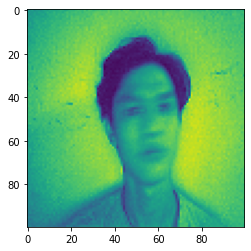

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X[2])

In [ ]:
import tensorflow as tf 
x_leftright = []
y_leftright  = []
for i in range(X.shape[0]):
  xi = tf.image.flip_left_right(X[i].reshape(100,100,1))
  yi = y[i]
  x_leftright.append(xi)
  y_leftright.append(yi)

In [ ]:
x_leftright = np.array(x_leftright)
y_leftright = np.array(y_leftright)

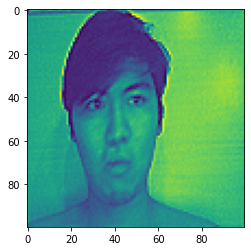

In [ ]:
plt.imshow(x_leftright[-2].reshape(100,100))

In [ ]:
x_leftright.shape


(63, 100, 100, 1)

In [ ]:
X = X.reshape(X.shape[0],100,100,1)

In [ ]:
X.shape

(63, 100, 100, 1)

In [ ]:
X_train = np.concatenate((X,x_leftright))
Y_train = np.concatenate((y,y_leftright))


In [ ]:
X_train.shape

(126, 100, 100, 1)

In [ ]:
Y_train.shape

(126,)

In [ ]:
keys = np.array(range(X_train.shape[0]))
np.random.shuffle(keys)
X_train = X_train[keys]
Y_train = Y_train[keys]

In [ ]:
#import thư viện
import numpy as np
from tensorflow import keras
from keras.layers import Activation
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import pickle


In [ ]:
Y_train = keras.utils.to_categorical(Y_train, 2)


In [ ]:
Y_train.shape

(126, 2)

In [ ]:
#build model phỏng theo VGG16 có lượt bỏ đơn giản 1 số layer

#phương pháp tính đầu ra của từng label là kết quả xác xuất rời rạc thông qua hàm softmax 
#kết quả sẽ là label có xác xuất lớn nhất 
#vd real label gồm y1 =[0,0,0], y2 = [0,0,1], y3 = [0,1,0]
#predicted label = [0.2,0.7,0.1] => kết quả  = y3 
#loss là categorial để tính sai số real label và predicted label theo kiểu mã hóa onehot 

#gọi model = hàm sequential để liên kết các layer
model = Sequential()
#tao lớp 2 lop tích chập đầu tiên có shape đầu vào là (100,100,1), kernel size là 3,số output filter là 64 , padding độn 0 và ham relu
#nhằm mục đích extract feature của data và share trong số 
model.add(Conv2D(input_shape=(100,100,1),filters=64,kernel_size=(3,3),padding="same", activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3),padding='same', activation='relu'))
#thu gọn kích thước output = maxpool có pool sized =2, độ trược 2 ô pixel
model.add(MaxPooling2D(pool_size=(2, 2),strides = 2))
#tăng output filter lên 128
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides = 2))
#tăng số out filter lên 256
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides = 2))
#tăng lên 512 số output filters
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides = 2))
#bỏ qua 1 số node = dropout
model.add(Dropout(0.25))
#làm phẳng dữ liệu = flatten
model.add(Flatten())
#tính toán output của fully connected layers thông qua hàm Dense
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
#đầuu ra là 2, đại diện cho 2 label và softmax để tính xác suất đầu ra lấy kết quả lớn nhất
model.add(Dense(2, activation='softmax'))
#chọn thuật toán tối ưu là adam, hàm loss là categorical_crossentropy
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 100, 100, 64)      640       
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 22, 22, 256)      

In [ ]:
hist = model.fit(X_train, Y_train,batch_size=128,epochs=50,verbose=1,validation_split=(0.1)) #tách 10% data làm validated data 

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 7.6552 - accuracy: 0.4248 - val_loss: 42.8532 - val_accuracy: 0.6154
Epoch 2/50
1/1 [==============================] - 0s 194ms/step - loss: 54.8758 - accuracy: 0.5133 - val_loss: 14.7364 - val_accuracy: 0.3846
Epoch 3/50
1/1 [==============================] - 0s 224ms/step - loss: 12.5824 - accuracy: 0.4867 - val_loss: 1.2898 - val_accuracy: 0.3846
Epoch 4/50
1/1 [==============================] - 0s 259ms/step - loss: 1.8808 - accuracy: 0.4956 - val_loss: 0.7418 - val_accuracy: 0.6154
Epoch 5/50
1/1 [==============================] - 0s 178ms/step - loss: 0.9759 - accuracy: 0.4602 - val_loss: 0.6463 - val_accuracy: 0.6154
Epoch 6/50
1/1 [==============================] - 0s 179ms/step - loss: 0.7166 - accuracy: 0.5664 - val_loss: 0.6645 - val_accuracy: 0.4615
Epoch 7/50
1/1 [==============================] - 0s 179ms/step - loss: 0.8037 - accuracy: 0.5133 - val_loss: 0.6192 - val_accuracy: 0.6154
Epoch 8/50
1/1 [===

In [ ]:
model.save('face.h5')

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array 
from keras.models import load_model
import numpy as np  
import matplotlib.pyplot as plt
import cv2 

# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(100, 100))	
	
	return img

[[3.2481868e-04 9.9967515e-01]]
expectation thanh


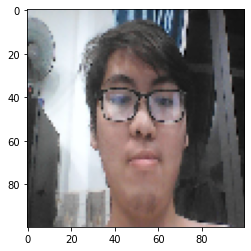

In [ ]:
labels = {0: 'minh',
          1: 'thanh'          
          }
model = load_model('face.h5')
	# load model
img = load_image('thanh(3).jpg')
plt.imshow(img)
img = img_to_array(img)
img.shape
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img = img.reshape(1,100,100,1)  
img.shape
result = model.predict(img)
print(result)
np.argmax(result) 
print('expectation',labels[np.argmax(result)]) 

[[7.5459646e-08 9.9999988e-01]]
expectation thanh


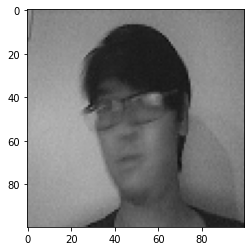

In [ ]:

model = load_model('face.h5')
	# load model
img = load_image('im22.jpg')
plt.imshow(img)
img = img_to_array(img)
img.shape
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#img = cv2.GaussianBlur(img,(11,11),0,0)
img = img.reshape(1,100,100,1)  
img.shape
result = model.predict(img)
print(result)
np.argmax(result) 
print('expectation',labels[np.argmax(result)]) 

[[0.23609456 0.7639054 ]]
expectation thanh


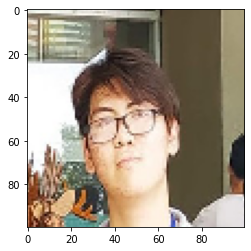

In [ ]:
model = load_model('face.h5')
	# load model
img = load_image('thanh3.jpg')
plt.imshow(img)
img = img_to_array(img)
img.shape
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#img = cv2.GaussianBlur(img,(11,11),0,0)
img = img.reshape(1,100,100,1)  
img.shape
result = model.predict(img)
print(result)
np.argmax(result) 
print('expectation',labels[np.argmax(result)]) 

[[1.0000000e+00 1.1907477e-19]]
expectation minh


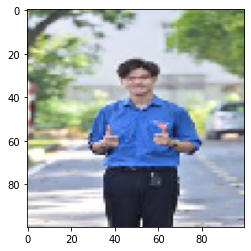

In [ ]:
model = load_model('face.h5')
	# load model
img = load_image('minh.jpg')
plt.imshow(img)
img = img_to_array(img)
img.shape
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#img = cv2.GaussianBlur(img,(11,11),0,0)
img = img.reshape(1,100,100,1)  
img.shape
result = model.predict(img)
print(result)
np.argmax(result) 
print('expectation',labels[np.argmax(result)]) 

[[1.000000e+00 5.241807e-14]]
expectation minh


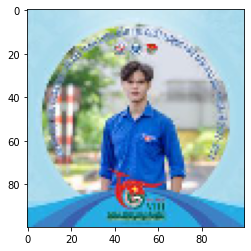

In [ ]:
model = load_model('face.h5')
	# load model
img = load_image('minh1.jpg')
plt.imshow(img)
img = img_to_array(img)
img.shape
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#img = cv2.GaussianBlur(img,(11,11),0,0)
img = img.reshape(1,100,100,1)  
img.shape
result = model.predict(img)
print(result)
np.argmax(result) 
print('expectation',labels[np.argmax(result)]) 

[[9.9999964e-01 3.0950275e-07]]
expectation minh


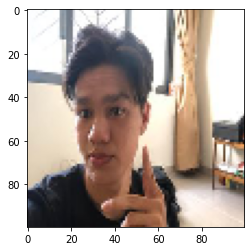

In [ ]:
model = load_model('face.h5')
	# load model
img = load_image('minh2.jpg')
plt.imshow(img)
img = img_to_array(img)
img.shape
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#img = cv2.GaussianBlur(img,(11,11),0,0)
img = img.reshape(1,100,100,1)  
img.shape
result = model.predict(img)
print(result)
np.argmax(result) 
print('expectation',labels[np.argmax(result)]) 

expectation thanh


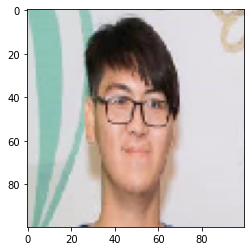

In [ ]:
model = load_model('face.h5')
	# load model
img = load_image('thanh4.jpg')
plt.imshow(img)
img = img_to_array(img)
img.shape
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#img = cv2.GaussianBlur(img,(11,11),0,0)
img = img.reshape(1,100,100,1)  
img.shape
result = model.predict(img)
#print(result)
np.argmax(result) 
print('expectation',labels[np.argmax(result)]) 

expectation thanh


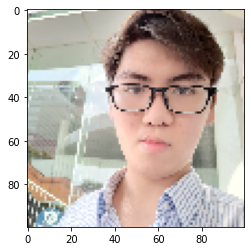

In [ ]:
model = load_model('face.h5')
	# load model
img = load_image('thanh.jpg')
plt.imshow(img)
img = img_to_array(img)
img.shape
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#img = cv2.GaussianBlur(img,(11,11),0,0)
img = img.reshape(1,100,100,1)  
img.shape
result = model.predict(img)
#print(result)
np.argmax(result) 
print('expectation',labels[np.argmax(result)]) 

expectation minh


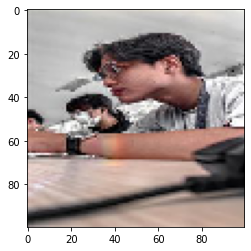

In [ ]:
model = load_model('face.h5')
	# load model
img = load_image('minh3.jpg')
plt.imshow(img)
img = img_to_array(img)
img.shape
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#img = cv2.GaussianBlur(img,(11,11),0,0)
img = img.reshape(1,100,100,1)  
img.shape
result = model.predict(img)
#print(result)
np.argmax(result) 
print('expectation',labels[np.argmax(result)]) 

expectation thanh


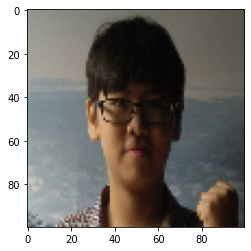

In [ ]:
model = load_model('face.h5')
	# load model
img = load_image('thanh5.jpg')
plt.imshow(img)
img = img_to_array(img)
img.shape
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#img = cv2.GaussianBlur(img,(11,11),0,0)
img = img.reshape(1,100,100,1)  
img.shape
result = model.predict(img)
#print(result)
np.argmax(result) 
print('expectation',labels[np.argmax(result)]) 

expectation minh


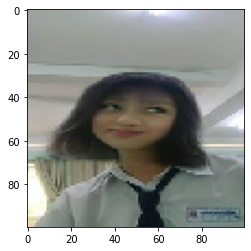

In [ ]:
model = load_model('face.h5')
	# load model
img = load_image('minh4.jpg')
plt.imshow(img)
img = img_to_array(img)
img.shape
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#img = cv2.GaussianBlur(img,(11,11),0,0)
img = img.reshape(1,100,100,1)  
img.shape
result = model.predict(img)
#print(result)
np.argmax(result) 
print('expectation',labels[np.argmax(result)]) 